In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd


data_dir = os.path.join(os.getcwd(), "data")
os.listdir(data_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [2]:

train = pd.read_csv(os.path.join(data_dir, "train.csv"), encoding="utf-8")
test = pd.read_csv(os.path.join(data_dir, "test.csv"), encoding="utf-8")
print("Train ", train.shape)
print("Test ", test.shape)

train.head().append(train.tail())

Train  (250000, 102)
Test  (150000, 101)


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0,-0.002350,59,0.766739,-1.350460,42.27270,16.68570,30.35990,1.267300,0.392007,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.296580,10.489800,15
1,1,0.784462,145,-0.463845,-0.530421,27324.90000,3.47545,160.49800,0.828007,3.735860,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.364700,1.143830,3
2,2,0.317816,19,-0.432571,-0.382644,1383.26000,19.71290,31.10260,-0.515354,34.430800,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.696790,12.305500,6
3,3,0.210753,17,-0.616454,0.946362,-119.25300,4.08235,185.25700,1.383310,-47.521400,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.456450,10.028800,2
4,4,0.439671,20,0.968126,-0.092546,74.30200,12.30650,72.18600,-0.233964,24.399100,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.784850,7.071970,1
249995,249995,0.923980,6,0.663212,-0.055120,6.61768,1.26619,40.44790,0.852375,25.522400,...,3517.97000,18.534200,1.41936,0.607504,4.950780,2.853420,0.961882,1.068010,1.437650,11
249996,249996,0.243556,7,-0.557062,1.333470,-54.88610,17.58310,212.96400,-1.204750,-128.385000,...,1945.81000,19.482200,1.60072,-0.154877,5.693280,1.994540,0.760925,1.427880,1.226720,5
249997,249997,0.046023,53,0.462863,0.704034,2062.94000,14.58160,11.42710,-0.509812,80.818000,...,-28.46890,11.008200,1.61080,-0.350927,27.986900,1.012690,0.830533,1.005470,0.455332,1
249998,249998,0.977330,12,-1.002880,0.576377,4741.16000,11.10090,3.81546,0.616191,118.902000,...,-275.53700,21.985700,3.16051,0.772058,2.592220,3.938260,0.697430,0.962347,7.415890,10
249999,249999,0.244233,51,0.729304,-0.702592,197.46200,19.02400,42.33370,0.465181,-115.398000,...,5387.25000,38.574600,3.61783,-0.544969,-0.987695,1.871910,0.452516,0.935411,28.912200,7


In [3]:
y = train["loss"]
X = train[[c for c in train.columns if c not in ("id", "loss")]]

In [4]:
# Create train and validation datasets:

np.random.seed(42)
ix = list(train.index)
np.random.shuffle(ix)

validation_size = 0.2

cutoff = int(len(ix) * validation_size)
X_validation = X.loc[ix[:cutoff]]
X_train = X.loc[ix[cutoff:]]
y_validation = y.loc[ix[:cutoff]]
y_train = y.loc[ix[cutoff:]]
print(f"Number of training examples:   {len(X_train)}")
print(f"Number of validation examples: {len(X_validation)}")

Number of training examples:   200000
Number of validation examples: 50000


In [ ]:
# Dimensionality reduction - see if there are redundant features:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Need to scale data first:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_validation_sc = pd.DataFrame(scaler.transform(X_validation), index=X_validation.index, columns=X_validation.columns)

# Then model with PCA:
pca_model = PCA(n_components=len(X_train_sc.columns)-1)
pca_model.fit(X_train_sc)
fig, ax = plt.subplots()
ax.plot(range(1, len(X_train_sc.columns), 1), np.cumsum(pca_model.explained_variance_ratio_))

In [7]:
from sklearn.metrics import mean_squared_error

def score_model(validation_pred, validation_true, model_name: str):
    score = mean_squared_error(validation_pred, validation_true) ** 0.5
    print(f"Model {model_name}:\n  RMSE on validation set = {score:.4f}")
    return score


def compare_pred_hist(validation_pred, validation_true: pd.Series, bins=20):
    """Compare model's predicted values with true values."""
    raw_df = pd.concat([
        pd.Series(validation_true.values, name="true"),
        pd.Series(baseline_pred, name="pred")
    ], axis=1)
    raw_df["diff"] = raw_df["pred"] - raw_df["true"]
    fig, ax = plt.subplots()
    ax.hist(raw_df["diff"], label="diff", alpha=0.25, bins=bins, color="r")
    ax.hist(raw_df["true"], label="true", alpha=0.25, bins=bins, color="blue")
    ax.hist(raw_df["pred"], label="pred", alpha=0.75, bins=bins, color="green")
    ax.legend()


In [10]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val, n_splits: int = 25):
    train_errors, val_errors = list(), list()
    chunk_size = len(X_train) // n_splits
    
    for i in range(n_splits):
        X_subset = X_train.iloc[0: chunk_size * (i+1)]
        print(len(X_subset))
        y_subset = y_train.iloc[0: chunk_size * (i+1)]
        model.fit(X_subset, y_subset)
        y_train_predict = model.predict(X_subset)
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_subset, y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    ax.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    ax.legend()
    ax.set_title("Learning Curve")
    return fig

In [20]:
model = LinearRegression()
n = 100000
model.fit(X_train.iloc[:n, ], y_train.iloc[:n])
train_pred = model.predict(X_train.iloc[:n, ])
print(mean_squared_error(y_train.iloc[:n], train_pred, squared=False))

val_pred = model.predict(X_validation)
print(mean_squared_error(y_validation, val_pred, squared=False))

7.9116196847445
7.8781312266358565


In [19]:
X_validation

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
38683,0.350894,11,0.532066,-0.846378,351.1160,1.740850,131.19900,-0.175430,174.29400,1.14402,...,0.832497,13028.1000,8.263590,1.60372,-0.515793,-1.062870,2.29640,0.682706,3.736590,26.66510
64939,0.694336,60,1.380260,0.621514,48.6641,7.469840,106.38000,0.681666,-3.56084,1.53357,...,2.405800,140.3980,-0.377886,4.21188,0.135265,-5.683290,2.37999,0.249169,1.620310,15.48560
3954,0.310044,22,0.870989,-0.872505,4165.5300,5.981530,302.96300,0.814370,192.29200,1.03052,...,0.641910,254.2760,18.159200,1.69890,0.538787,-0.082383,3.28431,0.497846,1.421850,10.36970
120374,0.449736,23,-3.320080,0.535662,221.8440,0.511201,7.66738,0.878341,-66.60980,1.24082,...,0.724922,17143.8000,16.709300,3.44528,-0.346934,3.745090,2.19290,0.760123,1.714160,5.37716
172861,0.609567,33,1.069800,1.162900,18938.5000,6.765720,196.47800,0.752956,10.19830,1.13004,...,0.485380,-42.3153,6.638530,3.84949,-1.148750,-18.826200,1.54535,0.293714,1.834110,2.44546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179545,0.992798,3,-2.507150,-0.724512,71.7791,6.648180,8.33978,1.225000,4.48586,1.19158,...,1.144700,681.5570,33.118300,1.59495,-1.297020,-2.106340,2.45618,0.474825,1.233070,7.57924
222647,0.897933,26,0.481948,1.164940,18.4496,11.241200,80.45420,0.496476,83.09660,1.14654,...,0.018245,1231.1500,2.528260,1.70889,1.101370,0.323634,1.48638,0.982144,2.624850,9.99234
171823,0.334574,73,0.665323,0.529473,975.6530,13.001900,248.03100,-2.172160,65.92530,1.36577,...,0.166247,1675.3300,17.835400,1.75289,-0.758416,3.185850,2.52751,0.556518,0.219067,12.49180
135782,0.122136,63,3.510930,-0.992197,-1691.5300,0.927694,128.43600,0.358540,-9.95634,1.10543,...,1.291990,786.6140,27.133000,1.26198,0.434883,13.844800,2.28249,0.924187,4.051860,14.59770


8000
16000
24000
32000
40000
48000
56000
64000
72000
80000
88000
96000
104000
112000
120000
128000
136000
144000
152000
160000
168000
176000
184000
192000
200000


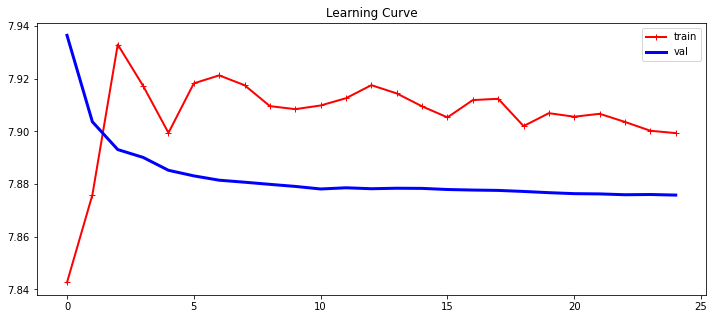

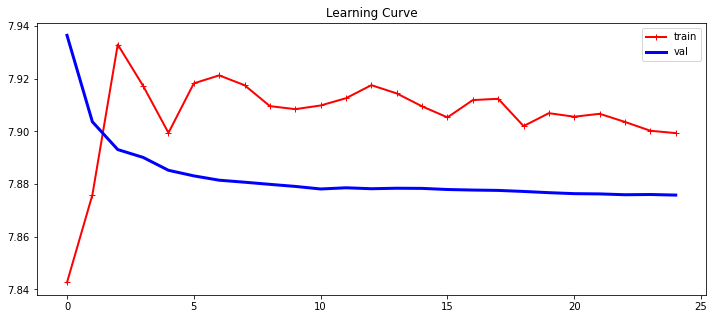

In [11]:
# Baseline model - linear regression:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

plot_learning_curves(model, X_train, y_train, X_validation, y_validation)
# model.fit(X_train, y_train)
# baseline_pred = model.predict(X_validation)
# baseline_score = score_model(baseline_pred, y_validation, "Baseline Regression")
# compare_pred_hist(baseline_pred, y_validation, 25)

In [ ]:
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")


plot_learning_curves(LinearRegression(), X_train, y_train)

In [ ]:
# Try splitting on feature identified in EDA:
X_low, X_high = X_train[X_train["f27"] <= 40000], X_train[X_train["f27"] > 40000]
X_val_low, X_val_high = X_validation[X_validation["f27"] <= 40000], X_validation[X_validation["f27"] > 40000]
y_low, y_high = y.loc[X_low.index], y.loc[X_high.index]
y_val_low, y_val_high = y_validation.loc[X_val_low.index], y_validation.loc[X_val_high.index]

low_model = LinearRegression()
low_model.fit(X_low, y_low)
low_pred = low_model.predict(X_val_low)
high_model = LinearRegression()
high_model.fit(X_high, y_high)
high_pred = high_model.predict(X_val_high)
all_pred = pd.Series(low_pred, index=X_val_low.index).append(pd.Series(high_pred, index=X_val_high.index))

lowhigh_score = score_model(all_pred.sort_index(), y_validation.sort_index(), "Low-High Regression")

In [ ]:
compare_pred_hist(all_pred.sort_index(), y_validation.sort_index(), 25)

In [ ]:
from functions import *

single_log_trans = [
    "f5", "f9", 
    "f13", "f16", 
    "f22", "f23", "f24", "f26", "f28", "f29",
    "f30", "f33", "f35",
    "f42", "f44", "f45", "f46", "f49",
    "f52", "f54", "f55", "f56", "f57", "f59",
    "f62", 
    "f75", "f78", "f79", 
    "f83", "f86", "f87", "f88", "f89", 
    "f90", "f91", "f92",

]
double_log_trans = [
    "f1", "f4", "f6",
    "f20", "f28",
    "f30", "f35", 
    "f44", 
    "f60", 
    "f89"
]

X_train_lt =  X_train_sc.copy()
X_validation_lt = X_validation_sc.copy()
for col in single_log_trans + double_log_trans:
    X_train_lt[col] = log_transform(X_train_lt[col])
    X_validation_lt[col] = log_transform(X_validation_lt[col])
    
for col in double_log_trans:
    X_train_lt[col] = log_transform(X_train_lt[col])
    X_validation_lt[col] = log_transform(X_validation_lt[col])


hist_x_logt = plot_hist_all_features(X_train_lt)

In [ ]:
# Linear regression on log transformed features:
from sklearn.linear_model import LinearRegression

logt_x_model = LinearRegression()
logt_x_model.fit(X_train_lt, y_train)
logt_x_pred = logt_x_model.predict(X_validation_lt)
logt_x_score = score_model(baseline_pred, y_validation, "Log-Transformed X Regression")

In [ ]:
# Baseline model - linear regression on log transformed features + log transformed target:
from sklearn.linear_model import LinearRegression

logt_xy_model = LinearRegression()
logt_xy_model.fit(X_train_lt, log_transform(y_train))
logt_xy_pred = logt_xy_model.predict(X_validation_lt)
logt_xy_score = score_model(np.exp(logt_xy_pred) - 1, y_validation, "Log Transformed XY Regression")

In [ ]:
# Try regularization:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

estimator = Ridge()
param_grid = {
    "alpha": np.logspace(-2, 5, 10)
}
gs = GridSearchCV(estimator, param_grid, scoring="neg_mean_squared_error")
gs.fit(X_train_lt, y_train)

score_model(gs.best_estimator_.predict(X_validation_lt), y_validation, "Ridge Regression")

In [ ]:
# Check for outliers removal. Plot scaled means and see how many are skewed by outliers.

fig, ax = plt.subplots()
_ = ax.hist(X_train_sc.mean())

Note: means all very close to zero (X-axis is on 10-15 scale!)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X["f14"], X["f21"])

In [ ]:
X.corr()

## Multimodality

In [ ]:
from functions import *

In [ ]:
# When we examine the X features, we say many that look multi-modeal:
all_dists = plot_hist_all_features(X, bins=100)

### GMM feature splitting

In [ ]:
# Select one of the strongly bimodal features and try to separate it with a GMM:
from sklearn.mixture import GaussianMixture

feature = "f12"

gmm_model = GaussianMixture(n_components=2, covariance_type="diag", random_state=42)
gmm_model.fit(X_train[[feature]])

In [ ]:
probas = gmm_model.predict_proba(X_train[[feature]])
class_pred = np.argmax(probas, axis=1)
gmm_table = X_train[[feature]].copy()
gmm_table["class"] = class_pred

fig, ax =  plt.subplots()
for class_label in gmm_table["class"].unique():
    data = gmm_table.loc[(gmm_table["class"] == class_label), feature]
    ax.hist(data, bins=1000, alpha=.75)
    ax.set_title(feature)

In [ ]:
lm_all = LinearRegression()
lm_all.fit(X_train[[feature]], y_train)
pred = lm_all.predict(X_validation[[feature]])
score_model(pred, y_validation, model_name="lm - full bimodal feature")

In [ ]:
probas_val = gmm_model.predict_proba(X_validation[[feature]])
class_pred_val = np.argmax(probas_val, axis=1)
gmm_table_val = X_validation[[feature]].copy()
gmm_table_val["class"] = class_pred_val


fig, ax =  plt.subplots()
for class_label in gmm_table_val["class"].unique():
    data = gmm_table_val.loc[(gmm_table_val["class"] == class_label), feature]
    ax.hist(data, bins=1000, alpha=.75)
    ax.set_title(f"{feature} - validation set")


In [ ]:
lm_gmm_0 = LinearRegression()
x0 = gmm_table.loc[gmm_table["class"] == 0, [feature]]
y0 = y.loc[x0.index]
lm_gmm_0.fit(x0, y0)
x0_val = gmm_table_val.loc[gmm_table_val["class"] == 0, [feature]]
pred0 = lm_gmm_0.predict(x0_val)
score_model(pred0, y_validation.loc[x0_val.index], model_name="lm - bimodal feature 0")

In [ ]:
lm_gmm_1 = LinearRegression()
x1 = gmm_table.loc[gmm_table["class"] == 1, [feature]]
y1 = y.loc[x1.index]
lm_gmm_1.fit(x1, y1)
x1_val = gmm_table_val.loc[gmm_table_val["class"] == 1, [feature]]
pred1 = lm_gmm_1.predict(x1_val)
score_model(pred1, y_validation.loc[x1_val.index], model_name="lm - bimodal feature 1")

In [ ]:
score_model(
    pd.Series(pred0, index=x0_val.index).append(pd.Series(pred1, index=x1_val.index)).sort_index(),
    y_validation.sort_index(),
    model_name="gmm models combined"
) 

### Quantile transformations

Can try using quantile transformations to convert bimodal distributions to normal.

In [ ]:
from sklearn.preprocessing import QuantileTransformer


output_distribution="uniform"

transformer = QuantileTransformer(
    n_quantiles=1000,
    output_distribution=output_distribution,
    random_state=42,
)

feature = "f32"

original_train = X_train[[feature]]
transformer.fit(original_train)
transformed_train = pd.DataFrame(transformer.transform(original_train), 
                                 index=original_train.index, columns=original_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(original_train[feature], bins=1000)
axes[1].hist(transformed_train[feature], bins=1000)
axes[0].set_title(f"{feature} original distribution")
axes[1].set_title(f"{feature} quantile transformed distribution")
plt.show()

simple_lm = LinearRegression()
simple_lm.fit(original_train, y_train)
pred = simple_lm.predict(X_validation[[feature]])
_ = score_model(pred, y_validation, model_name="Untransformed simple lm")

simple_lm = LinearRegression()
simple_lm.fit(transformed_train, y_train)
transformed_val = transformer.transform(X_validation[[feature]])
pred = simple_lm.predict(transformed_val)
_ = score_model(pred, y_validation, model_name="Transformed simple lm")

### Interaction/Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
poly.fit(X_train)

In [ ]:
X_train_poly = pd.DataFrame(poly.transform(X_train), index=X_train.index, columns=poly.get_feature_names())

In [ ]:
X_val_poly = pd.DataFrame(poly.transform(X_validation), index=X_validation.index, columns=poly.get_feature_names())

In [ ]:
sq_feature = [c for c in X_train_poly.columns if "^2" in c]
sq_dists = plot_hist_all_features(X_train_poly[sq_feature], bins=100)

In [ ]:

def indices_match(X, y):
    assert np.array_equal(np.array(X.index), np.array(y.index)), "Mismatched X, y indices."
    

def mini_batches(X, y, n: int = 100):
    indices_match(X, y)
    index = X.index
    while True:
        next_batch = np.random.choice(index, size=n, replace=False)
        yield(X.loc[next_batch], y.loc[next_batch])


from sklearn.linear_model import SGDRegressor

model = SGDRegressor()
batches = mini_batches(X_train_poly, y_train)

epochs = 5
rmse_train, rmse_validation = list(), list()
for e in range(epochs):
    X_batch, y_batch = next(batches)
    model.partial_fit(X_batch, y_batch)
    train_pred = model.predict(X_train_poly)
    train_score = mean_squared_error(y_train, train_pred, squared=False)
    rmse_train.append(train_score)
    val_pred = model.predict(X_val_poly)
    val_score = mean_squared_error(y_validation, val_pred, squared=False)
    rmse_validation.append(val_score)

In [ ]:
rmse_train, rmse_validation

In [ ]:
from sklearn.preprocessing import StandardScaler

X_mini = X_train_poly.iloc[:10000]
y_mini = y_train.iloc[:10000]

scaler = StandardScaler()
scaler.fit(X_mini)
X_mini_s = pd.DataFrame(scaler.transform(X_mini), 
                        index=X_train_poly.iloc[:10000].index, columns=X_train_poly.columns)

X_val_s = pd.DataFrame(scaler.transform(X_val_poly),
                    index=X_validation.index, columns=X_validation.columns)

In [ ]:
model = SGDRegressor(alpha=0.1, penalty="l1")
model.fit(X_mini_s, y_mini)
val_pred = model.predict(X_val_s)
mean_squared_error(y_validation, val_pred, squared=False)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
pcad = pca.fit_transform(X_mini_s)

In [ ]:
pcad.shape

In [ ]:
pd.DataFrame(X_mini_s, index=X_train_poly.iloc[:10000].index, columns=X_train_poly.columns)

In [ ]:
from functions import *

plot_hist_all_features()